In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/myopia.csv"
MyopiaData = pd.read_csv(url)

In [3]:
MyopiaData.head()

,ID,STUDYYEAR,MYOPIC,AGE,GENDER,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,1,1992,1,6,1,-0.052,21.89,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,2,1995,0,6,1,0.608,22.38,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,3,1991,0,6,1,1.179,22.49,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,4,1990,1,6,1,0.525,22.20,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,1995,0,5,0,0.697,23.29,3.676,3.454,16.16,14,0,0,0,4,4,1,0


Here is our dataset dictionary: https://www.umass.edu/statdata/statdata/data/myopia.pdf

#### We are interested in finding out what contributes to Myopia the most. My grandmother always told me not to watch TV, play with computer since it will affect my eyes. (She was strangely find with studying!). It sounds like Drs share the same point of view with my grandmother " http://www.allaboutvision.com/conditions/myopia.htm "

#### We are DataScientist and don't trust our grandmothers or DRs unless we find the same result! Now, let's go and explore Myopia!




In [4]:
# Year of study and id should not affect anything so we disregard them in this study. 
# we consider two types of inputs - first all general inputs - i.e. physical and external inputs
# second only external inputs
X1 = MyopiaData[['SPHEQ','AL','ACD','LT','VCD','AGE','GENDER','SPORTHR','READHR','COMPHR','STUDYHR','TVHR','DIOPTERHR','MOMMY','DADMY']]
X2 = MyopiaData[['AGE','GENDER','SPORTHR','READHR','COMPHR','STUDYHR','TVHR','DIOPTERHR','MOMMY','DADMY']]
y = MyopiaData['MYOPIC']


Run your regression line on X1 and interpret your MOMMY AND DADMY coefficients.

In [5]:
lm = LogisticRegression()
lm.fit(X1,y)
print lm.coef_
print lm.intercept_

[[-3.39425426  0.11608725  0.77257167 -0.31202044 -0.32603631  0.00379047
   0.53625105 -0.04739496  0.0976417   0.05015837 -0.13224782 -0.00438634
  -0.00788793  0.63899595  0.72678878]]
[ 0.05253685]


It sounds like genetics affects Myopia significantly. Odds of Myopia increases 63% and 73% with positive case of myopia for Mothers and Fathers respectively. 

#### Use confusion matrix and estimate False negative rate and False positive rate

In [6]:
from sklearn.metrics import confusion_matrix
y_hat = lm.predict(X1)
confusion_matrix(y_hat, y)

array([[524,  53],
       [ 13,  28]])

#### Use 10-fold cross-validation to measure accuracy of your predictions

In [7]:
cross_val_score(lm,X1,y,cv=10).mean() #88.6%

0.88674716493330974

#### In your dataset, what percentage of cases are myopic?

In [8]:
MyopiaData['MYOPIC'].mean() # only 13 percent

0.13106796116504854

#### Based on the result you found above, is your prediction precision good or bad?

Answer: It is not too impressive. If you would predict no one was myopic, your error would be 13.1% with your current model your error is 11.4%. 

#### Imagine you would like to decrease your False negative rate. What can you do in order to make it less than 2%? 

In [14]:
def PredictThreshold(Predictprob,Threshhold):
    y_predict = 0
    if (Predictprob >= Threshhold):
        y_predict = 1
    return y_predict

y_hat_probability = lm.predict_proba(X1).T[1]
y_hat_predict_threshold = []
threshold = 0.52
for i in range(0,len(y_hat_probability)):
    y_hat_predict_threshold.append(PredictThreshold(y_hat_probability[i],threshold))

FNR = float(confusion_matrix(y_hat_predict_threshold,y)[1,0])/((confusion_matrix(y, y_hat_predict_threshold)[1,0])
                                                           + (confusion_matrix(y, y_hat_predict_threshold)[0,0]))
print FNR
print(confusion_matrix(y_hat_predict_threshold,y))

0.0189003436426
[[526  56]
 [ 11  25]]


## Answer: You need to change your threshold to 0.52 . If you were to decrease you False Positive Rate, then you would need to increase your threshold. 

#### Now let's run a logistic regression line on X2 and see if we can confirm our Grandmothers' claims!

In [15]:
lm.fit(X2,y)
NameOfVariables = ['AGE','GENDER','SPORTHR','READHR','COMPHR','STUDYHR','TVHR','DIOPTERHR','MOMMY','DADMY']
Var_coef = zip(lm.coef_[0,:],NameOfVariables)
print Var_coef
print lm.intercept_

[(-0.14479375150954149, 'AGE'), (0.24541585373931735, 'GENDER'), (-0.047119473691703252, 'SPORTHR'), (0.068796762399704336, 'READHR'), (0.0093705300498213937, 'COMPHR'), (-0.071573823359504712, 'STUDYHR'), (-0.003641904635989172, 'TVHR'), (0.0067679725847197185, 'DIOPTERHR'), (0.7282891608379638, 'MOMMY'), (0.83081091557828157, 'DADMY')]
[-1.73861851]


Interpret your results specifically on StudyHr, TVH, and COMPHR, Gender: It seems like TVH, and StudyHr and COMPHR  - if significant - only marginally affect myopia. It sounds like the odds of positive myopia case for Females is 24% more than males. 

#### Now it's time for regularization and choosing the best predictors:

In [16]:
#Let's first standardize our data - use X1
def Standardize(X):
    X_Max = X.max()
    X_Min = X.min()
    X_Standardized = (X-X_Min)/(X_Max - X_Min)
    return X_Standardized

NameOfVariables = ['SPHEQ','AL','ACD','LT','VCD','AGE','GENDER','SPORTHR','READHR','COMPHR','STUDYHR','TVHR','DIOPTERHR','MOMMY','DADMY']
for i in NameOfVariables:
    MyopiaData[i] = Standardize(MyopiaData[i])
    
X1 = MyopiaData[NameOfVariables]    

<IPython.core.display.Javascript object>


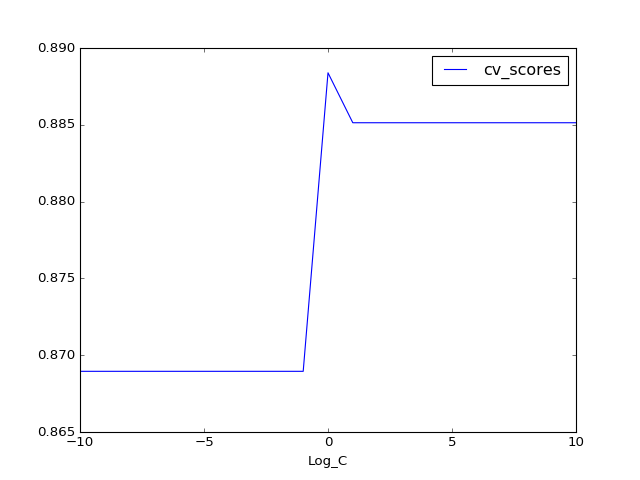

In [17]:
# Try testing and plot using different C as input and l1 penalty
c_list = np.logspace(-10,10,21) 
c_index = np.linspace(-10,10,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score, penalty = "l1")
    cv_scores.append(cross_val_score(lm,X1,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )

<IPython.core.display.Javascript object>


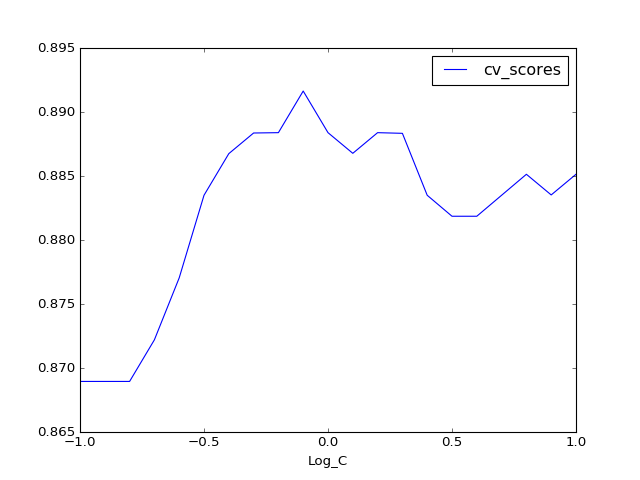

In [18]:
# localize your search around the maximum value you found
c_list = np.logspace(-1,1,21) 
c_index = np.linspace(-1,1,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score, penalty = "l1")
    cv_scores.append(cross_val_score(lm,X1,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )
# it sounds like our best choice is C = -0.1  (we chose the most restrictive option)

In [19]:
lm = LogisticRegression(C = 10**(-.1), penalty = "l1")
lm.fit(X1,y)
Var_coef = zip(lm.coef_[0,:],NameOfVariables)
sorted(Var_coef)

[(-13.561541091084386, 'SPHEQ'),
 (-0.99734547131337392, 'SPORTHR'),
 (-0.27284432598621988, 'STUDYHR'),
 (0.0, 'AGE'),
 (0.0, 'AL'),
 (0.0, 'COMPHR'),
 (0.0, 'DIOPTERHR'),
 (0.0, 'LT'),
 (0.0, 'TVHR'),
 (0.0, 'VCD'),
 (0.2951144570314827, 'READHR'),
 (0.53011916324737152, 'GENDER'),
 (0.64896834800876457, 'MOMMY'),
 (0.78370115073495461, 'DADMY'),
 (0.99638672496610836, 'ACD')]

#### What is your conclusions about your Grandmothers' and some other Drs' claims?

Answer: They are simply wrong based on our dataset! COMPHR, TVHR, did have minimal effect on chance of Myopia while genetics, ACD, and Gender significantly increased the odds of myopia. To our surprise studyhr and sporthr seems to decrease the odds of myopia. I think this is only correct in our dataset. Our dataset is composed of children under 10. May be those who have eyesight issues do not have that much incentive to involve in sports or may have difficulty studying. 

#### Draw ROC curve for your best tuned model. 

In [20]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
y_hat_probability = lm.predict_proba(X1).T[1]  #T[1] returns probability of belonging to class
print(roc_auc_score(y, y_hat_probability))
vals = roc_curve(y, y_hat_probability) # the value is not too bad

0.889555601536


<IPython.core.display.Javascript object>


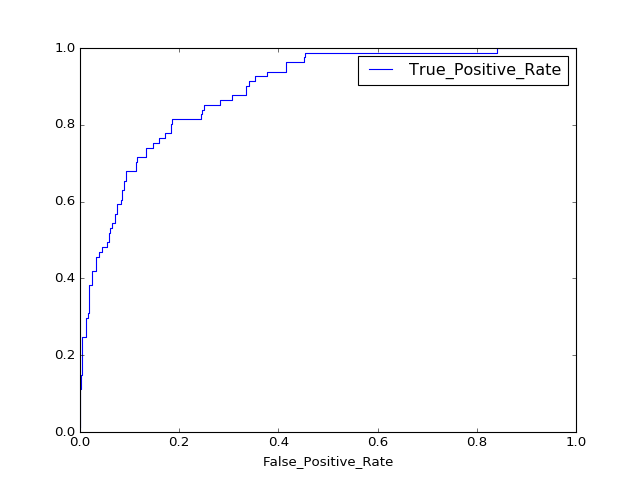

In [21]:


Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) #beautiful Graph